<a href="https://colab.research.google.com/github/19k41a05g6/project/blob/main/nlp_use_lstm_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.5 MB/s 
     |████████████████████████████████| 570.3 MB 319 bytes/s 
     |████████████████████████████████| 1.3 MB 45.3 MB/s 
     |████████████████████████████████| 5.6 MB 32.1 MB/s 
     |████████████████████████████████| 462 kB 49.2 MB/s 
     |████████████████████████████████| 14.8 MB 42.6 MB/s 
     |████████████████████████████████| 132 kB 60.6 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=1e5f1eaaabbc230830cb5ff3c68b8ac1eb83cab64d2ecfd4821de25973e95196
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=8402988ef7c57bf2c4d807d982ab7f2c64f70656d2351d78327aee32df36a55d
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c

In [2]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence, text

from tensorflow.keras.optimizers import Adam


RANDOM_SEED = 42

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

In [2]:
import pandas as pd
df_reviews = pd.read_csv("/content/drive/MyDrive/reviews.csv")
df_reviews


,review,review_type
0,I grew up (b. 1965) watching and loving the Th...,bad
1,"When I put this movie in my DVD player, and sa...",bad
2,Why do people who do not know what a particula...,bad
3,Even though I have great interest in Biblical ...,bad
4,Im a die hard Dads Army fan and nothing will e...,good
...,...,...
19995,"I was required to watch the movie for my work,...",bad
19996,"""White Noise"" had potential to be one of the m...",bad
19997,The Five Deadly Venoms is a great kung-fu acti...,good
19998,Ali G Indahouse has got to be one of the funni...,good


In [ ]:
import re
df = df_reviews
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    text = text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    return(text)

data = df.copy()
cleanedText = []
for text in data["review"].values:
    text = text+" "
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)
    text = re.sub(r'(@){1}.+?( ){1}', ' ', text)
    text = re.sub(r'(#){1}.+?( ){1}', ' ', text)
    cleanedText.append(text_to_wordlist(text))
data['cleanedText'] = cleanedText

data.head(15)


,review,review_type,cleanedText
0,I grew up (b. 1965) watching and loving the Th...,bad,i grew up b 1965 watching and loving the thund...
1,"When I put this movie in my DVD player, and sa...",bad,when i put this movie in my dvd player and sat...
2,Why do people who do not know what a particula...,bad,why do people who do not know what a particula...
3,Even though I have great interest in Biblical ...,bad,even though i have great interest in biblical ...
4,Im a die hard Dads Army fan and nothing will e...,good,im a die hard dads army fan and nothing will e...
5,A terrible movie as everyone has said. What ma...,bad,a terrible movie as everyone has said what mad...
6,Finally watched this shocking movie last night...,good,finally watched this shocking movie last night...
7,I caught this film on AZN on cable. It sounded...,bad,i caught this film on azn on cable it sounded ...
8,It may be the remake of 1987 Autumn's Tale aft...,good,it may be the remake of 1987 autumn tale after...
9,My Super Ex Girlfriend turned out to be a plea...,good,my super ex girlfriend turned out to be a plea...


In [ ]:
data.drop(columns=['review'],axis=1, inplace=True)
data.rename(columns = {'cleanedText':'review'}, inplace = True)
df_reviews = data
df_reviews

,review_type,review
0,bad,i grew up b 1965 watching and loving the thund...
1,bad,when i put this movie in my dvd player and sat...
2,bad,why do people who do not know what a particula...
3,bad,even though i have great interest in biblical ...
4,good,im a die hard dads army fan and nothing will e...
...,...,...
19995,bad,i was required to watch the movie for my work ...
19996,bad,white noise had potential to be one of the mo...
19997,good,the five deadly venoms is a great kung - fu ac...
19998,good,ali g indahouse has got to be one of the funni...


In [ ]:
fig = px.histogram(df_reviews, x="review_type", title='no of +ve and -ve', text_auto=True)
fig.show()


In [ ]:
good_reviews = df_reviews[df_reviews.review_type == "good"]
bad_reviews = df_reviews[df_reviews.review_type == "bad"]

In [ ]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

In [ ]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED, replace=True)

df_review_resampled = good_df.append(bad_reviews).reset_index(drop=True)
df_review_resampled.shape

(20048, 2)

In [ ]:
df_review_resampled

,review_type,review
0,good,bill crain rarer than rare lasher movie certai...
1,good,things that are only just now news were taken ...
2,good,having recently purchased universal marlene di...
3,good,it finally hit me watching my vhs of christmas...
4,good,a documentary about a nomadic tribe in tibet g...
...,...,...
20043,bad,why did the histories of mary and rhoda have t...
20044,bad,first of all let me say that i am in no way de...
20045,bad,what else can you say about this movie except ...
20046,bad,i was required to watch the movie for my work ...


In [ ]:
label_enc = preprocessing.LabelEncoder()
encoded_review = label_enc.fit_transform(df_review_resampled.review_type.values)

In [ ]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_review_resampled.review, 
    encoded_review, 
    test_size=0.25, 
    random_state=RANDOM_SEED
  )

In [ ]:
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 15036/15036 [1:21:54<00:00,  3.06it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 5012/5012 [30:18<00:00,  2.76it/s]


In [ ]:
print(X_train.shape, X_test.shape)

(15036, 512) (5012, 512)


In [ ]:
print(y_train.shape, y_test.shape)

(15036,) (5012,)


In [ ]:
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    )

In [ ]:
X_train_reshaped = X_train[:, newaxis,:]
X_test_reshaped = X_test[:, newaxis,:]

In [ ]:
X_train_reshaped.shape

(15036, 1, 512)

In [ ]:
# input_shape
1,X_train_reshaped.shape[2]

(1, 512)

In [ ]:
def build_model_lstm():
    model = Sequential()
    model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
    model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))
    model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
model_lstm = build_model_lstm()

In [ ]:
history = model_lstm.fit(
    X_train_reshaped, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
846/846 [==============================] - 18s 16ms/step - loss: 0.5986 - accuracy: 0.7320 - val_loss: 0.5232 - val_accuracy: 0.8211
Epoch 2/10
846/846 [==============================] - 13s 15ms/step - loss: 0.5033 - accuracy: 0.8232 - val_loss: 0.4863 - val_accuracy: 0.8331
Epoch 3/10
846/846 [==============================] - 13s 15ms/step - loss: 0.4651 - accuracy: 0.8332 - val_loss: 0.4600 - val_accuracy: 0.8371
Epoch 4/10
846/846 [==============================] - 13s 15ms/step - loss: 0.4349 - accuracy: 0.8421 - val_loss: 0.4489 - val_accuracy: 0.8311
Epoch 5/10
846/846 [==============================] - 13s 15ms/step - loss: 0.4087 - accuracy: 0.8522 - val_loss: 0.4238 - val_accuracy: 0.8444
Epoch 6/10
846/846 [==============================] - 13s 15ms/step - loss: 0.3841 - accuracy: 0.8613 - val_loss: 0.4141 - val_accuracy: 0.8351
Epoch 7/10
846/846 [==============================] - 13s 15ms/step - loss: 0.3568 - accuracy: 0.8753 - val_loss: 0.3977 - val_accuracy:

In [ ]:
model_lstm.evaluate(X_test_reshaped, y_test)

157/157 [==============================] - 1s 6ms/step - loss: 0.3911 - accuracy: 0.8506


[0.391099214553833, 0.8505586385726929]

In [ ]:
model_lstm.save("lstm_sentiment_model4.h5")

In [ ]:
model_lstm.save("/content/drive/MyDrive/lstm_sentiment_model3.h5")

In [ ]:
imported_model1 = tf.keras.models.load_model('/content/drive/MyDrive/lstm_sentiment_model.h5')
imported_model2 = tf.keras.models.load_model('/content/drive/MyDrive/lstm_sentiment_model2.h5')
imported_model3 = tf.keras.models.load_model('/content/drive/MyDrive/lstm_sentiment_model3.h5')

imported_model1.summary()

imported_model2.summary()

imported_model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            787456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dense (Dense)                (None, 1, 1)              65        
Total params: 1,034,049
Trainable params: 1,034,049
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 256)            787456    
________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            787456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dense (Dense)                (None, 1, 1)              65        
Total params: 1,034,049
Trainable params: 1,034,049
Non-trainable params: 0
_________________________________________________________________


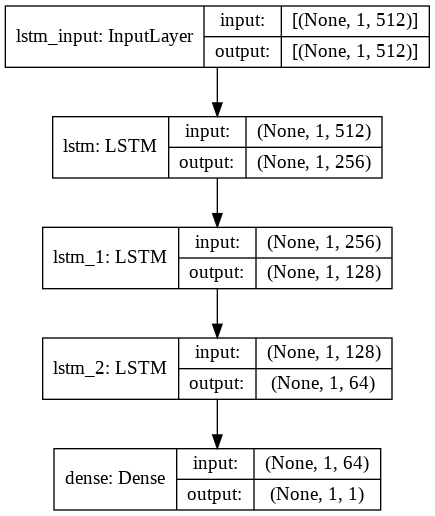

In [ ]:
plot_model(imported_model1)